# 图像插值

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [3]:
src = cv2.imread('../datas/f2.jpg')
rgb = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
rgb_f = rgb.astype(np.float32)

In [10]:
def Key(x, a=-0.5):
    ax = abs(x)
    y = 0
    if 0 <= x < 1 or -1 < x <= 0:
        y = (a+2)*ax*ax*ax - (a+3)*ax*ax + 1
    elif 1 <= x < 2 or -2 < x <= -1:
        y = a*ax*ax*ax - 5*a*ax*ax + 8*a*ax - 4*a
    return y

def oMom(x):
    ax = abs(x)
    y = 0
    if 0 <= x < 1 or -1 < x <= 0:
        y = 0.5*ax*ax*ax - ax*ax + ax/14.0 + 13.0/21
    elif 1 <= x < 2 or -2 < x <= -1:
        y = -ax*ax*ax/6.0 + ax*ax - 85.0/42*ax + 29.0/21
    return y

def osc(x):
    ax = abs(x)
    y = 0
    if 0 <= x < 1 or -1 < x <= 0:
        y = (1.0808 - 0.168*ax*ax - 0.9129*ax) / (ax*ax - 0.8319*ax + 1.0808)
    elif 1 <= x < 2 or -2 < x <= -1:
        y = (0.3905 + 0.1953*ax*ax - 0.5858*ax) / (ax*ax - 2.4402*ax + 1.7676)
    return y

def blending_Key_oMom(x):
    return 0.5*Key(x) + 0.5*oMom(x)

def blending_Key_osc(x):
    return 0.5*Key(x) + 0.5*osc(x)

def interpolate_at(loc, input_array, interpolate_function=osc, cap_low=0, cap_high=255):
    """
    interpolation 1d function at index loc (could be float)
    """
    n = len(input_array)
    # obtain pixel indices
    i1 = int(loc)
    i0 = max(0, i1-1)
    i2 = min(n-1, i1+1)
    i3 = min(n-1, i2+1)
    x1 = i1 - loc 
    x0 = x1 - 1
    x2 = x1 + 1
    x3 = x2 + 1
    w0 = interpolate_function(x0)
    w1 = interpolate_function(x1)
    w2 = interpolate_function(x2)
    w3 = interpolate_function(x3)
    y = input_array[i0] * w0 + input_array[i1] * w1
    y += input_array[i2] * w2 + input_array[i3] * w3
    y = min(y, max(y, cap_low), cap_high)
    return y

def interpolate_1d(input_array, factor=2, interpolate_function=Key):
    n = len(input_array)
    n_inter = int(n * factor)
    output_array = np.zeros(n_inter)
    for i in range(n_inter):
    # find the floating point position in the original array
        loc = i * 1.0 / factor
        output_array[i] = interpolate_at(loc, input_array, interpolate_function=Key)
    return output_array

def interpolate_h(input_array, factor=2, interpolate_function=Key):
    h, w = input_array.shape
    h_inter = int(h * factor)
    output_array = np.zeros((h_inter, w))
    for i in range(w):
        output_array[:, i] = interpolate_1d(input_array[:, i], factor, interpolate_function)
    return output_array

def interpolate_w(input_array, factor=2, interpolate_function=Key):
    h, w = input_array.shape
    w_inter = int(w * factor)
    output_array = np.zeros((h, w_inter))
    for i in range(h):
        output_array[i] = interpolate_1d(input_array[i], factor, interpolate_function)
    return output_array

def interpolate_2d(input_array, factor=2, interpolate_function=Key):
    h, w = input_array.shape
    h_inter = int(h * factor)
    w_inter = int(w * factor)
    h_interpolat = interpolate_h(input_array, factor, interpolate_function)
    output_array = interpolate_w(h_interpolat, factor, interpolate_function)
    return output_array

def interpolate_color_img(input_img, factor=2, interpolate_function=Key):
    h, w, c = input_img.shape
    h_inter = int(h * factor)
    w_inter = int(w * factor)
    output_img = np.zeros((h_inter, w_inter, 3))
      # interpolate per channel (r, g, b)
    for ic in range(c):
        input_img_ch = input_img[:,:,ic]
        output_img[:,:,ic] = interpolate_2d(input_img_ch, factor, interpolate_function)
    return np.asarray(output_img, dtype=np.uint8)


In [13]:
output_oMom = interpolate_color_img(rgb, 5, interpolate_function=oMom)

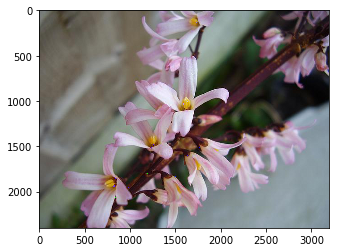

In [14]:
plt.imshow(output_oMom)